In [22]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)


files = glob.glob('./server_results/finetuning/*.csv')
files = glob.glob('./server_results/finetuning_valentine/OpenData/*.csv')


In [23]:
def handle_matcher_names(df):




    substitutions = {
        'header_values_default': 'Default (Type)',
        'header_values_verbose': 'Verbose (Type)',
        'header_values_repeat': 'Repeat (Type)',
        'header_values_prefix': 'Prefix (Type)',
        'header_only': 'Header only',
        'header_values_verbose_notype': 'Verbose',
        'header_values_columnvaluepair_notype': 'Header-Value repeat',
        'header_header_values_repeat_notype': 'Repeat',
        'header_values_default_notype': 'Default',
    }

    df['encoding_mode'] = df['encoding_mode'].replace(substitutions)

    # print(df['encoding_mode'].unique())

    to_show = [
        #'Default (Type)',
        'Default',
        'Verbose',
        'Repeat',
        'Header-Value repeat',
        'Header only',
    ]

#     ['Default (Type)' 'Prefix (Type)' 'Repeat (Type)' 'Verbose (Type)'
#  'Column only' 'Verbose' 'ColVal Pairs' 'Repeat' 'Default']

    df = df[df['encoding_mode'].isin(to_show)].copy()


    
    
    df['sampling_mode'] = df['sampling_mode'].str.title()
    df['sampling_mode'] = df['sampling_mode'].str.replace('_Sampling', '')
    df = df[df['sampling_mode'] != 'Mixed'].copy()

    sampling_size = 10
    df = df[df['sampling_size'] == sampling_size].copy()

    df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'}, inplace=True)
    df.rename(columns={'mrr': 'MRR'}, inplace=True)

    return df


def best_aggregate(df, metric='mrr'):

    df_grouped = df.groupby(['type'])[metric].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
    df_grouped = df_grouped.sort_values(by='mean', ascending=False)
    # print(df_grouped.head(20).to_string())
    return df_grouped



def plot(df, ax, x, y,  legend=False, save=None):
    

    order = df.groupby(x)['MRR'].mean().sort_values(ascending=False).index

    

    sns.barplot(
        data=df,
        x=x,
        y=y,
        ax=ax,
        palette=sns.color_palette("pastel"),  # Use a better palette
        order=order,
        # ci=None  # Disable confidence intervals
    )

    # sns.boxplot(
    #     data=df,
    #     x=x,
    #     hue=hue,
    #     y=y,
    #     ax=ax,
    #     palette=sns.color_palette("Set2"),  # Use a better palette
    #     order=order,
    #     hue_order=hue_order
    #     # , showfliers=False
    #     ,fliersize=0.5

    # )

    #ax.set_xlabel(x.replace('_', ' ').title(), fontsize=14)
    ax.set_xlabel('Column representation', fontsize=14)

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(y.upper(), fontsize=14)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    if legend:
        ax.set_xlabel('')

    if legend:
        ax.legend(
            loc='lower center',
            bbox_to_anchor=(0.48, 0.98),
            frameon=False
        )
    else:
        ax.get_legend().remove()

    sns.despine()



def plot_grouped_bar(df, x, metrics, figsize=(9, 8), save=None):

    fig, axis = plt.subplots(len(metrics),1 , figsize=figsize, sharex=True)

    for i, metric in enumerate(metrics):
        ax = axis[i]
        plot(df, ax, x,  metric, legend=(i==0), save=None)


    if save is not None:
        fig.savefig(save, format='pdf', dpi=300)

    plt.tight_layout()
    plt.show()
   

In [24]:
all_dfs_list = []
datasetnames = []
for file in files:
    datasetname = file.split('OpenData-opendata-')[1].split('_results.csv')[0]
    datasetname= datasetname.replace('_results_.csv', '')

    print(datasetname)

    df = pd.read_csv(file)

    df['type'] = datasetname
    # df = handle_matcher_names(df)
    
    all_dfs_list.append(df)


all_dfs = pd.concat(all_dfs_list)

all_dfs = all_dfs.sort_values(by='type')

all_dfs.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'}, inplace=True)
all_dfs.rename(columns={'mrr': 'MRR'}, inplace=True)


df_ft = all_dfs[all_dfs['method'] == 'MatchMakerFT']
df_ft = df_ft.sort_values(by='type')

df_ftgpt = all_dfs[all_dfs['method'] == 'MatchMakerFTGPT']
df_ftgpt = df_ftgpt.sort_values(by='type')


header_values_repeat-exact
header_values_verbose-exact_semantic
header_values_repeat-semantic
header_values_default-exact
header_values_default-exact_semantic
header_values_verbose-semantic
header_values_verbose-exact
header_values_default-semantic


In [25]:
res = best_aggregate(df_ft, metric='MRR')
res.to_csv('best_aggregate_mrr.csv', index=False)
res

,type,mean,median,min,max,std
7,header_values_verbose-semantic,0.850532,0.888500,0.436289,1.0,0.152309
1,header_values_default-exact_semantic,0.843859,0.882407,0.250000,1.0,0.165914
6,header_values_verbose-exact_semantic,0.840562,0.870833,0.353853,1.0,0.162452
0,header_values_default-exact,0.824143,0.868000,0.433333,1.0,0.172169
5,header_values_verbose-exact,0.817398,0.830780,0.291990,1.0,0.180990
2,header_values_default-semantic,0.805015,0.825000,0.394082,1.0,0.189302
3,header_values_repeat-exact,0.754628,0.772113,0.274667,1.0,0.227534
4,header_values_repeat-semantic,0.749851,0.770055,0.243056,1.0,0.214774


In [26]:
res = best_aggregate(df_ft, metric='Recall@GT')
res.to_csv('best_aggregate_recall.csv', index=False)
res

,type,mean,median,min,max,std
2,header_values_default-semantic,0.748693,0.742857,0.0,1.0,0.237603
6,header_values_verbose-exact_semantic,0.742977,0.784314,0.0,1.0,0.255405
1,header_values_default-exact_semantic,0.730855,0.800000,0.0,1.0,0.282596
7,header_values_verbose-semantic,0.729067,0.764706,0.0,1.0,0.271110
5,header_values_verbose-exact,0.711485,0.733333,0.0,1.0,0.270699
0,header_values_default-exact,0.698432,0.720000,0.0,1.0,0.285617
3,header_values_repeat-exact,0.632264,0.600000,0.0,1.0,0.301427
4,header_values_repeat-semantic,0.603307,0.600000,0.0,1.0,0.311974


In [27]:
res  = best_aggregate(df_ftgpt, metric='MRR')
res.to_csv('best_aggregate_mrr_ftgpt.csv', index=False)
res

,type,mean,median,min,max,std
7,header_values_verbose-semantic,0.938538,0.980000,0.727407,1.0,0.080087
6,header_values_verbose-exact_semantic,0.927105,0.980000,0.627778,1.0,0.095937
5,header_values_verbose-exact,0.917332,0.975510,0.604762,1.0,0.104567
1,header_values_default-exact_semantic,0.916869,0.964286,0.705714,1.0,0.095437
0,header_values_default-exact,0.890559,0.933333,0.600000,1.0,0.119590
2,header_values_default-semantic,0.864576,0.920000,0.488889,1.0,0.145721
4,header_values_repeat-semantic,0.820643,0.898693,0.333333,1.0,0.188812
3,header_values_repeat-exact,0.806231,0.866667,0.333333,1.0,0.197989


In [28]:
res = best_aggregate(df_ftgpt, metric='Recall@GT')
res.to_csv('best_aggregate_recall_ftgpt.csv', index=False)
res

,type,mean,median,min,max,std
3,header_values_repeat-exact,0.629925,0.640000,0.0,1.0,0.308672
2,header_values_default-semantic,0.626760,0.657143,0.0,1.0,0.291150
4,header_values_repeat-semantic,0.622477,0.628571,0.0,1.0,0.307038
0,header_values_default-exact,0.585164,0.600000,0.0,1.0,0.300564
6,header_values_verbose-exact_semantic,0.526569,0.533333,0.0,1.0,0.300130
5,header_values_verbose-exact,0.521617,0.533333,0.0,1.0,0.299045
7,header_values_verbose-semantic,0.485666,0.480000,0.0,1.0,0.295033
1,header_values_default-exact_semantic,0.479786,0.466667,0.0,1.0,0.314223


/var/folders/kt/v8ddhvyx5kv0zx8hg7_zkb4m0000gn/T/ipykernel_6503/3198871463.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


AttributeError: 'NoneType' object has no attribute 'remove'

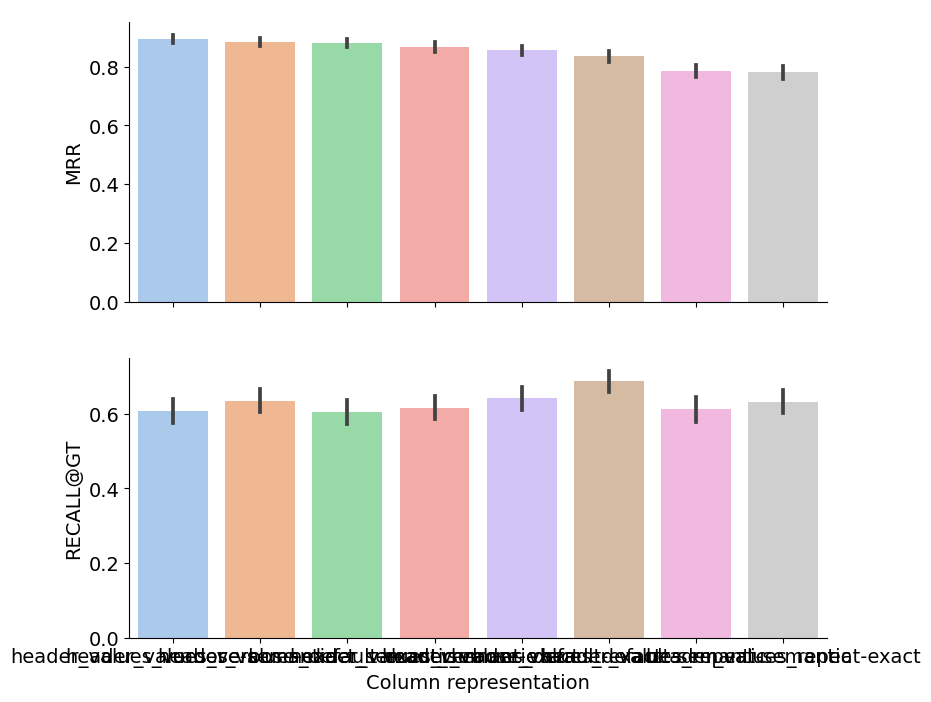

In [29]:
metric1 = 'MRR'
metric2 = 'Recall@GT'
metrics = [metric1, metric2]

plot_grouped_bar(all_dfs, x='type', metrics=metrics, figsize=(9, 8), save=None)